[INFO] Loaded 4000 rows from 2010-01-05 to 2025-11-26
[INFO] Split sizes — train: 2382, val: 794, test: 795
[INFO] Fitting RF config n100_d3_leaf1 ...
[INFO] Fitting RF config n100_d3_leaf5 ...
[INFO] Fitting RF config n100_d5_leaf1 ...
[INFO] Fitting RF config n100_d5_leaf5 ...
[INFO] Fitting RF config n100_dNone_leaf1 ...
[INFO] Fitting RF config n100_dNone_leaf5 ...
[INFO] Fitting RF config n200_d3_leaf1 ...
[INFO] Fitting RF config n200_d3_leaf5 ...
[INFO] Fitting RF config n200_d5_leaf1 ...
[INFO] Fitting RF config n200_d5_leaf5 ...
[INFO] Fitting RF config n200_dNone_leaf1 ...
[INFO] Fitting RF config n200_dNone_leaf5 ...
[INFO] Validation results (sorted by AUC):
                 key  n_estimators  max_depth  min_samples_leaf   auc_val  \
6      n200_d3_leaf1           200        3.0                 1  0.690790   
7      n200_d3_leaf5           200        3.0                 5  0.690783   
0      n100_d3_leaf1           100        3.0                 1  0.690564   
1      n100_d

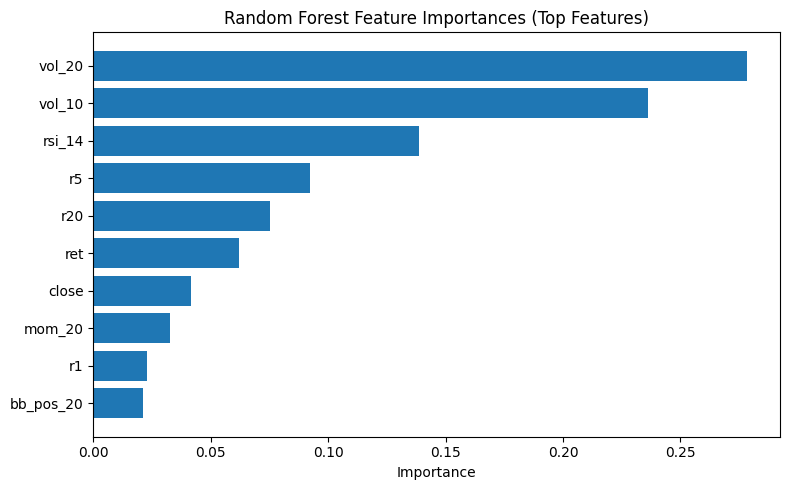

In [2]:
"""
Level-54 — Random Forest Regime Classifier with Volatility-Sensitive Position Sizing
------------------------------------------------------------------------------------

DSA concept (what you are practicing here)
------------------------------------------
This level is built to exercise three core DSA concepts:

1) Sliding / rolling windows on time-series
   We use rolling sums of returns to define a *forward* turbulence / volatility
   proxy over a fixed horizon (e.g., 10 trading days). This is a classic
   sliding window pattern over an array: at each index t, you aggregate
   elements from t ... t+h-1. In pandas, rolling(...) is just a higher-level
   implementation of a two-pointer / prefix-sum style algorithm.

2) Trees and ensembles (Random Forests)
   A Random Forest is a collection (ensemble) of decision trees. Each tree is a
   recursively defined data structure:
       - each node stores: split feature, threshold, left/right children,
       - leaves store: class probabilities.
   The forest itself is an array/list of these tree objects. Conceptually you
   are working with hierarchical (tree) structures and a bag of them (an array
   of trees), which is a classic DSA combination.

3) Dictionaries + grid search with sorting
   Hyperparameter tuning is implemented by:
       - iterating over a small grid of (n_estimators, max_depth, min_samples_leaf),
       - storing validation metrics and feature importances in dictionaries
         keyed by a string describing that configuration,
       - turning those into a DataFrame and sorting by a metric (like AUC).
   This is a simple but extremely useful pattern in practice:
       brute-force search over a grid → aggregate stats in dict → sort/argmax.

Quant idea (what this model does financially)
---------------------------------------------
We build a **regime classifier** for a single asset (default SPY) using daily
data. The label is not "up vs down", but whether the *magnitude* of forward
10-day return moves is high or low:

    fut_ret_h = sum_{i=0..h-1} r_{t+i}
    turb_h    = |fut_ret_h|
    y = 1 if turb_h > median(turb_h) else 0

So y=1 roughly corresponds to "high-turbulence / high-move regimes" and y=0 to
"calmer regimes." Using past features (returns, volatility, momentum, etc.), a
RandomForestClassifier is trained to predict this binary regime.

Once we have probabilistic regime estimates on the test set, we define a very
simple volatility-sensitive strategy:

    - Position = 1.0 in calm regimes (predicted low turbulence).
    - Position = 0.5 in predicted high-turbulence regimes (we cut risk in half).

We then compute Sharpe ratio and a “regime hit-rate” (how often the predicted
regime matches realized turbulence class) to see if the classifier improves
risk-adjusted returns vs always being fully invested.

External resources (to study similar ideas in practice)
-------------------------------------------------------
You can read about Random Forests with feature importance in the scikit-learn
documentation and examples:
    - scikit-learn: RandomForestClassifier user guide and examples.

For finance / regime-context examples, search for:
    - "Random forest market regime classification"
    - "Tree-based volatility state models"
    - "Machine learning for volatility regimes scikit-learn"
You’ll find notebooks and blog posts where forests are used to classify bull /
bear or high/low volatility states on equity indices and traded futures.

Script summary
--------------
1) Downloads daily prices via yfinance and falls back to a synthetic geometric
   random walk if download fails.
2) Builds features: recent returns, volatility, momentum, Bollinger-band
   position, and an RSI-like oscillator.
3) Builds a turbulence label based on the absolute forward h-day return,
   binarized at the median.
4) Splits data chronologically into train / validation / test.
5) Runs a small grid search over RandomForest hyperparameters using validation
   AUC to select the best configuration.
6) Re-fits the best forest on train+validation, evaluates on test, and computes
   regime hit-rate and Sharpe of the volatility-sensitive strategy.
7) Saves:
     - Per-date test predictions to CSV.
     - A feature-importance table across hyperparameters to CSV.
     - A JSON with best model info and grid metrics.
"""

from dataclasses import dataclass
from typing import Dict, List

import json
import math

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


# ---------------------------- Config ---------------------------- #


@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2010-01-01"

    # labeling horizon (forward window) in trading days
    label_horizon: int = 10

    # train/val/test fractions (chronological)
    train_frac: float = 0.6
    val_frac: float = 0.2  # test_frac = 1 - train_frac - val_frac

    # Random Forest hyperparameter grid
    n_estimators_grid: List[int] = None
    max_depth_grid: List[int] = None  # use None for "no limit"
    min_samples_leaf_grid: List[int] = None

    random_state: int = 54

    # trading rule
    position_high_turb: float = 0.5   # exposure in high-turbulence regimes
    position_low_turb: float = 1.0    # exposure in low-turbulence regimes

    # output paths
    out_preds_csv: str = "level54_rf_regime_predictions.csv"
    out_importance_csv: str = "level54_rf_feature_importance_grid.csv"
    out_metrics_json: str = "level54_rf_regime_metrics.json"

    def __post_init__(self):
        if self.n_estimators_grid is None:
            self.n_estimators_grid = [100, 200]
        if self.max_depth_grid is None:
            self.max_depth_grid = [3, 5, None]
        if self.min_samples_leaf_grid is None:
            self.min_samples_leaf_grid = [1, 5]


# ------------------------- Utility funcs ------------------------ #


def synthetic_price_series(
    n: int = 2500,
    start_price: float = 100.0,
) -> pd.Series:
    """Fallback geometric random walk if yfinance fails."""
    rng = np.random.default_rng(54)
    mu_daily = 0.06 / 252.0
    sigma_daily = 0.2 / math.sqrt(252.0)
    rets = rng.normal(mu_daily, sigma_daily, size=n)
    prices = start_price * np.exp(np.cumsum(rets))
    idx = pd.date_range("2010-01-01", periods=n, freq="B")
    return pd.Series(prices, index=idx, name="close")


def load_price_series(cfg: Config) -> pd.DataFrame:
    """
    Robust loader around yfinance.

    Handles:
        - Series
        - DataFrame with OHLCV
        - MultiIndex columns
    and falls back to synthetic data on error/empty.
    """
    try:
        px = yf.download(
            cfg.symbol,
            start=cfg.start,
            auto_adjust=True,
            progress=False,
        )
    except Exception:
        px = pd.DataFrame()

    if px is None or len(px) == 0:
        print("[WARN] yfinance download failed. Using synthetic price path.")
        close = synthetic_price_series()
    else:
        if isinstance(px, pd.Series):
            close_obj = px
        elif isinstance(px, pd.DataFrame):
            if "Close" in px.columns:
                close_obj = px["Close"]
            else:
                if isinstance(px.columns, pd.MultiIndex):
                    # Try to pick a ("Close", ticker) or similar
                    candidates = [
                        c
                        for c in px.columns
                        if str(c[0]).lower() == "close"
                        or str(c[-1]).lower() == "close"
                    ]
                    if len(candidates) > 0:
                        close_obj = px[candidates[0]]
                    else:
                        close_obj = px.iloc[:, 0]
                else:
                    # No "Close" column; pick first numeric column
                    num_cols = px.select_dtypes(include=[np.number])
                    if num_cols.shape[1] > 0:
                        close_obj = num_cols.iloc[:, 0]
                    else:
                        close_obj = px.iloc[:, 0]
        else:
            raise RuntimeError("Unexpected type from yfinance download.")

        # Make sure we have a 1D array
        close_arr = np.asarray(close_obj, dtype=float).reshape(-1)
        close = pd.Series(close_arr, index=close_obj.index, name="close")

    df = pd.DataFrame({"close": close.astype(float)})
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna().copy()
    return df


def sharpe_ratio(ret: pd.Series, ann_factor: float = 252.0) -> float:
    """Simple Sharpe estimate with ddof=1 for std."""
    if ret is None or len(ret) < 2:
        return 0.0
    mu = float(ret.mean())
    sigma = float(ret.std(ddof=1))
    if sigma <= 0:
        return 0.0
    return float(mu / sigma * math.sqrt(ann_factor))


def hit_rate_binary(pred: pd.Series, true: pd.Series) -> float:
    """
    Hit-rate between two binary label series (0/1).
    """
    aligned = pd.concat([pred, true], axis=1).dropna()
    if aligned.shape[0] == 0:
        return 0.0
    return float((aligned.iloc[:, 0] == aligned.iloc[:, 1]).mean())


# ----------------------- Feature engineering -------------------- #


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature set:

    r1, r5, r20:
        1, 5, 20 day log returns.
    vol_10, vol_20:
        rolling volatility of returns.
    mom_20:
        20-day log momentum.
    bb_pos_20:
        normalized position inside 20-day Bollinger band.
    rsi_14:
        RSI-like oscillator built from EWMA of up/down moves.
    """
    out = df.copy()

    out["r1"] = out["ret"].shift(1)
    out["r5"] = out["ret"].rolling(5).sum().shift(1)
    out["r20"] = out["ret"].rolling(20).sum().shift(1)

    out["vol_10"] = out["ret"].rolling(10).std().shift(1)
    out["vol_20"] = out["ret"].rolling(20).std().shift(1)

    out["mom_20"] = np.log(out["close"] / out["close"].shift(20))

    rolling_mean = out["close"].rolling(20).mean()
    rolling_std = out["close"].rolling(20).std()
    out["bb_pos_20"] = (out["close"] - rolling_mean) / (rolling_std + 1e-12)

    def rsi_like(ret: pd.Series, span: int = 14) -> pd.Series:
        up = ret.clip(lower=0.0)
        dn = -ret.clip(upper=0.0)
        avg_up = up.ewm(alpha=1 / span, adjust=False).mean()
        avg_dn = dn.ewm(alpha=1 / span, adjust=False).mean()
        rs = avg_up / (avg_dn + 1e-12)
        rsi = 100.0 - 100.0 / (1.0 + rs)
        return rsi

    out["rsi_14"] = rsi_like(out["ret"])

    out = out.dropna().copy()
    return out


def build_turbulence_labels(feat_df: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    Turbulence / regime label:

        fut_ret_h(t) = sum_{i=0..h-1} ret_{t+i}
        turb_h(t)    = |fut_ret_h(t)|

    y = 1  (high-turbulence regime)  if turb_h > median(turb_h)
        0  (low-turbulence regime)   otherwise
    """
    rets = feat_df["ret"]
    # Forward horizon sum; use shift so window covers [t .. t+h-1]
    fut_ret = rets.rolling(horizon).sum().shift(-horizon + 1)
    turb = fut_ret.abs()

    # Global median threshold (ignores NaNs)
    thresh = float(turb.median(skipna=True))
    y = (turb > thresh).astype(int)

    labels = pd.DataFrame(
        {
            "fut_ret_h": fut_ret,
            "turb": turb,
            "y": y,
        }
    )
    return labels


# ---------------------- Time splits & model --------------------- #


def chrono_splits(
    data: pd.DataFrame,
    train_frac: float,
    val_frac: float,
) -> Dict[str, pd.DataFrame]:
    """
    Chronological splits: train, val, test.

    Lengths:
        n_train = floor(train_frac * n)
        n_val   = floor(val_frac * n)
        n_test  = n - n_train - n_val
    """
    n = len(data)
    n_train = int(train_frac * n)
    n_val = int(val_frac * n)
    n_test = n - n_train - n_val
    if n_test <= 0:
        raise ValueError("Not enough data for test split; adjust fractions.")

    train = data.iloc[:n_train].copy()
    val = data.iloc[n_train : n_train + n_val].copy()
    test = data.iloc[n_train + n_val :].copy()

    return {"train": train, "val": val, "test": test}


def rf_key(n_estimators: int, max_depth, min_leaf: int) -> str:
    """Helper to create a compact key for a RF config."""
    d = "None" if max_depth is None else str(max_depth)
    return f"n{n_estimators}_d{d}_leaf{min_leaf}"


def fit_rf_for_config(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    n_estimators: int,
    max_depth,
    min_leaf: int,
    cfg: Config,
) -> Dict[str, float]:
    """
    Fit a RandomForestClassifier for a given hyperparameter tuple,
    and evaluate metrics on the validation set.
    """
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_leaf,
        random_state=cfg.random_state,
        class_weight="balanced",
        n_jobs=-1,
    )
    rf.fit(X_train.values, y_train.values)

    proba_val = rf.predict_proba(X_val.values)[:, 1]
    y_pred_val = (proba_val >= 0.5).astype(int)

    try:
        auc_val = roc_auc_score(y_val.values, proba_val)
    except ValueError:
        auc_val = float("nan")

    acc_val = accuracy_score(y_val.values, y_pred_val)

    importances = rf.feature_importances_.ravel()

    return {
        "auc_val": float(auc_val) if np.isfinite(auc_val) else float("nan"),
        "acc_val": float(acc_val),
        "importances": importances,
        "rf": rf,
    }


def refit_best_rf(
    data_split: Dict[str, pd.DataFrame],
    X_cols: List[str],
    best_cfg: Dict[str, object],
    cfg: Config,
) -> RandomForestClassifier:
    """
    Refit RF on train+val with the best hyperparameters,
    return the fitted forest.

    Fix: coerce max_depth into int or None, because grid_df turns None→NaN
    and ints→floats like 3.0, which sklearn rejects.
    """
    train = data_split["train"]
    val = data_split["val"]
    df_tv = pd.concat([train, val], axis=0)

    X_tv = df_tv[X_cols]
    y_tv = df_tv["y"].astype(int)

    raw_md = best_cfg["max_depth"]
    if raw_md is None:
        max_depth = None
    elif isinstance(raw_md, float):
        if np.isnan(raw_md):
            max_depth = None
        else:
            max_depth = int(raw_md)
    else:
        max_depth = int(raw_md)

    rf = RandomForestClassifier(
        n_estimators=int(best_cfg["n_estimators"]),
        max_depth=max_depth,
        min_samples_leaf=int(best_cfg["min_samples_leaf"]),
        random_state=cfg.random_state,
        class_weight="balanced",
        n_jobs=-1,
    )
    rf.fit(X_tv.values, y_tv.values)
    return rf


# ----------------------------- IO ------------------------------- #


def save_predictions(
    test_df: pd.DataFrame,
    p_high: pd.Series,
    regime_pred: pd.Series,
    strat_ret: pd.Series,
    cfg: Config,
) -> None:
    out = pd.DataFrame(
        {
            "close": test_df["close"],
            "ret": test_df["ret"],
            "fut_ret_h": test_df["fut_ret_h"],
            "turb": test_df["turb"],
            "label_y": test_df["y"],
            "p_high_turb": p_high,
            "regime_pred": regime_pred,
            "strat_ret": strat_ret,
        }
    )
    out.to_csv(cfg.out_preds_csv, index=True)
    print(f"[OK] Saved test predictions → {cfg.out_preds_csv}")


def save_importance_grid(
    feature_names: List[str],
    importance_map: Dict[str, np.ndarray],
    cfg: Config,
) -> None:
    """
    Save feature importances for each hyperparameter configuration.

    Rows = feature names
    Columns = config keys (e.g. "n100_d3_leaf1")
    """
    rows = []
    for feat_idx, feat in enumerate(feature_names):
        row = {"feature": feat}
        for key, imp_vec in importance_map.items():
            if feat_idx < len(imp_vec):
                row[key] = float(imp_vec[feat_idx])
            else:
                row[key] = float("nan")
        rows.append(row)

    df_imp = pd.DataFrame(rows)
    df_imp.to_csv(cfg.out_importance_csv, index=False)
    print(f"[OK] Saved feature importance grid → {cfg.out_importance_csv}")


def save_metrics(
    best_row: Dict[str, object],
    grid_df: pd.DataFrame,
    test_metrics: Dict[str, float],
    cfg: Config,
) -> None:
    payload = {
        "best_config": {
            "n_estimators": int(best_row["n_estimators"]),
            "max_depth": (
                None
                if (
                    isinstance(best_row["max_depth"], float)
                    and np.isnan(best_row["max_depth"])
                )
                else best_row["max_depth"]
            ),
            "min_samples_leaf": int(best_row["min_samples_leaf"]),
            "val_auc": float(best_row["auc_val"]),
            "val_acc": float(best_row["acc_val"]),
        },
        "test_metrics": test_metrics,
        "grid_metrics": grid_df.to_dict(orient="records"),
    }
    with open(cfg.out_metrics_json, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2)
    print(f"[OK] Saved metrics → {cfg.out_metrics_json}")


def plot_feature_importance(
    feature_names: List[str],
    importances: np.ndarray,
    top_k: int = 10,
) -> None:
    """
    Simple bar plot of top_k features by importance for the best RF.
    """
    if importances is None or len(importances) == 0:
        return

    idx_sorted = np.argsort(-importances)
    top_idx = idx_sorted[:top_k]
    top_feats = [feature_names[i] for i in top_idx]
    top_vals = importances[top_idx]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(top_feats)), top_vals)
    plt.yticks(range(len(top_feats)), top_feats)
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title("Random Forest Feature Importances (Top Features)")
    plt.tight_layout()
    plt.show()


# --------------------------- Pipeline --------------------------- #


def run_pipeline(cfg: Config) -> None:
    # 1) Load prices
    df = load_price_series(cfg)
    print(
        f"[INFO] Loaded {len(df)} rows from {df.index.min().date()} "
        f"to {df.index.max().date()}"
    )

    # 2) Features + labels
    feat = build_features(df)
    lab = build_turbulence_labels(feat, cfg.label_horizon)

    data = pd.concat([feat, lab], axis=1).dropna().copy()

    # 3) Chronological splits
    splits = chrono_splits(data, cfg.train_frac, cfg.val_frac)
    train = splits["train"]
    val = splits["val"]
    test = splits["test"]

    # X columns are everything except label and label-related columns
    X_cols = [c for c in data.columns if c not in ("y", "fut_ret_h", "turb")]

    X_train = train[X_cols]
    y_train = train["y"].astype(int)
    X_val = val[X_cols]
    y_val = val["y"].astype(int)
    X_test = test[X_cols]
    y_test = test["y"].astype(int)

    print(
        f"[INFO] Split sizes — "
        f"train: {len(train)}, val: {len(val)}, test: {len(test)}"
    )

    # 4) Grid search over RF hyperparameters
    results = []
    importance_map: Dict[str, np.ndarray] = {}
    rf_map: Dict[str, RandomForestClassifier] = {}

    for n_est in cfg.n_estimators_grid:
        for max_d in cfg.max_depth_grid:
            for leaf in cfg.min_samples_leaf_grid:
                key = rf_key(n_est, max_d, leaf)
                print(f"[INFO] Fitting RF config {key} ...")
                res = fit_rf_for_config(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    n_estimators=n_est,
                    max_depth=max_d,
                    min_leaf=leaf,
                    cfg=cfg,
                )
                results.append(
                    {
                        "key": key,
                        "n_estimators": n_est,
                        "max_depth": max_d,
                        "min_samples_leaf": leaf,
                        "auc_val": res["auc_val"],
                        "acc_val": res["acc_val"],
                    }
                )
                importance_map[key] = res["importances"]
                rf_map[key] = res["rf"]

    grid_df = pd.DataFrame(results).sort_values("auc_val", ascending=False)
    print("[INFO] Validation results (sorted by AUC):")
    print(grid_df)

    # 5) Choose best config by validation AUC
    best_row = grid_df.iloc[0].to_dict()
    best_key = best_row["key"]
    print(
        f"[INFO] Best RF config = {best_key} with val AUC="
        f"{best_row['auc_val']:.4f}, acc={best_row['acc_val']:.4f}"
    )

    # 6) Refit on train+val with best config
    best_cfg = {
        "n_estimators": best_row["n_estimators"],
        "max_depth": best_row["max_depth"],
        "min_samples_leaf": best_row["min_samples_leaf"],
    }
    best_rf = refit_best_rf(splits, X_cols, best_cfg, cfg)

    # 7) Evaluate on test
    p_high_test = pd.Series(
        best_rf.predict_proba(X_test.values)[:, 1],
        index=X_test.index,
        name="p_high_turb",
    )
    regime_pred = (p_high_test >= 0.5).astype(int)

    try:
        auc_test = roc_auc_score(y_test.values, p_high_test.values)
    except ValueError:
        auc_test = float("nan")

    acc_test = accuracy_score(y_test.values, regime_pred.values)
    regime_hit = hit_rate_binary(regime_pred, y_test)

    # Strategy: lower exposure in predicted high-turbulence regimes
    positions = pd.Series(
        cfg.position_low_turb,
        index=X_test.index,
        name="position",
    )
    positions[regime_pred == 1] = cfg.position_high_turb

    strat_ret = positions * df["ret"].loc[positions.index]
    strat_ret.name = "strat_ret"

    sharpe_strat = sharpe_ratio(strat_ret)
    sharpe_buyhold = sharpe_ratio(df["ret"].loc[strat_ret.index])

    test_metrics = {
        "auc_test": float(auc_test) if np.isfinite(auc_test) else float("nan"),
        "acc_test": float(acc_test),
        "regime_hit_rate": float(regime_hit),
        "sharpe_strat": float(sharpe_strat),
        "sharpe_buyhold": float(sharpe_buyhold),
        "n_test": int(len(test)),
        "position_high_turb": float(cfg.position_high_turb),
        "position_low_turb": float(cfg.position_low_turb),
    }

    print("[INFO] Test metrics:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v}")

    # 8) Save outputs
    save_predictions(test, p_high_test, regime_pred, strat_ret, cfg)
    save_importance_grid(X_cols, importance_map, cfg)
    save_metrics(best_row, grid_df, test_metrics, cfg)

    # 9) Plot feature importances for the best RF fit on train+val
    try:
        best_imp = best_rf.feature_importances_.ravel()
        plot_feature_importance(X_cols, best_imp, top_k=10)
    except Exception:
        pass


# ----------------------------- Main ----------------------------- #


if __name__ == "__main__":
    # Make it Jupyter-safe by stripping unwanted CLI args
    import sys

    sys.argv = [sys.argv[0]]
    cfg = Config()
    run_pipeline(cfg)
